# Preprocessing and exploring the SVHN dataset to build a deep CNN network for house number recognition

# Introduction
We are using the "The Street View House Numbers (SVHN) Datase" by Stanford University. The following informations are copied from the website http://ufldl.stanford.edu/housenumbers/ to produce an self-contained document.

## The Street View House Numbers (SVHN) Dataset 


SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

### Overview
- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
- Comes in two formats:
    1. Original images with character level bounding boxes.
    2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).
    
### Downloads

- Format 1: Full Numbers: train.tar.gz, test.tar.gz , extra.tar.gz (Note: for non-commercial use only)

![alt text](http://ufldl.stanford.edu/housenumbers/examples_new.png)

These are the original, variable-resolution, color house-number images with character level bounding boxes, as shown in the examples images above. (The blue bounding boxes here are just for illustration purposes. The bounding box information are stored in digitStruct.mat instead of drawn directly on the images in the dataset.) Each tar.gz file contains the orignal images in png format, together with a digitStruct.mat file, which can be loaded using Matlab. The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Eg: digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image. 

- Format 2: Cropped Digits: train_32x32.mat, test_32x32.mat , extra_32x32.mat (Note: for non-commercial use only) 

![alt text](http://ufldl.stanford.edu/housenumbers/32x32eg.png)

Character level ground truth in an MNIST-like format. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i).

### Reference
Please cite the following reference in papers using this dataset:

Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011. (PDF)
Please use http://ufldl.stanford.edu/housenumbers as the URL for this site when necessary

For questions regarding the dataset, please contact streetviewhousenumbers@gmail.com



## Important: I will use the format 1 - full numbers.

The reason is, that this will allows not only to train a classifier for house number recognition but also a regression model to find the bounding boxes of a full house number on an image using the full house-number images together with the character level bounding boxes (this bounding boxes will be replaced during preprocessing with one bounding box for the full house number)

## Import all required modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import tarfile
import h5py
from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import range
from six.moves.urllib.request import urlretrieve
from IPython.display import display, Image
from scipy import ndimage
import numpy as np

# Get the Data
## Download the train, test and extra dataset

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
def download(filename, force=False):
  """Download a file if not present, and check that it's has the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename

trainFilename = download('train.tar.gz')
testFilename = download('test.tar.gz')
extraFilename = download('extra.tar.gz')

print("Loading done")

Loading done


## Extract data files

In [3]:
def extractFiles(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  dataFolders = root
  print(dataFolders)
  return dataFolders
  
trainFolder = extractFiles(trainFilename)
testFolder = extractFiles(testFilename)
extraFolder = extractFiles(extraFilename)
print ("Extracting done")

train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test
extra already present - Skipping extraction of extra.tar.gz.
extra
Extracting done


# Preprocessing
## Load and process bounding boxes and filenames from digitStruct file

The bounding box information are stored in digitStruct.mat instead of drawn directly on the images in the dataset.) Each tar.gz file contains the orignal images in png format, together with a digitStruct.mat file, which can be loaded using Matlab. The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Eg: digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image. 



In [4]:
#Helper Methods to read attributes of digitStruct.mat and imagesize of images
from PIL import Image

def getPictureName(digitStruct,index):
    x=digitstruct[digitstruct['digitStruct']['name'][index][0]].value.tostring()
    name="".join(map(chr, x)).replace("\x00", "")
  #  return digitStruct[digitStruct['digitStruct']['name'][index][0]].value.tostring().replace("\x00", "")
    return name


def getBBoxAttr(digitstruct, index, attr):
    attribute = digitstruct[digitstruct['digitStruct']['bbox'][index][0]][attr].value.squeeze()
    if attribute.dtype == 'float64':
        return attribute.reshape(-1)
    else:
        return np.array([digitstruct[x].value for x in attribute]).squeeze()

def getBBox(digitstruct,index):
    bbox = {}
    bbox['height'] = getBBoxAttr(digitstruct, index,'height')
    bbox['label'] = getBBoxAttr(digitstruct, index,'label')
    bbox['left'] = getBBoxAttr(digitstruct, index,'left')
    bbox['top'] = getBBoxAttr(digitstruct, index,'top')
    bbox['width'] = getBBoxAttr(digitstruct, index,'width')
    return bbox
    
def getImageInfo(folder,digitstruct,index):
    info=getBBox(digitstruct,index)
    info['name']=getPictureName(digitstruct,index)
    fullname = os.path.join(folder, info['name'])
    im = Image.open(fullname)
    info['imgwidth']=im.size[0]
    info['imgheight']=im.size[1]
    return info
   
def getAllImageInfos(folder):
    digitstruct=h5py.File(os.path.join(folder,'digitStruct.mat'),'r')
    return [getImageInfo(folder,digitstruct,i) for i in range(len(digitstruct['digitStruct']['name']))]
 

In [8]:
f=os.path.join('extra','digitStruct.mat')
digitstruct=h5py.File(f, 'r')
getImageInfo("extra",digitstruct,33402)


{'height': array([ 39.,  39.,  39.]),
 'imgheight': 68,
 'imgwidth': 129,
 'label': array([  1.,   2.,  10.]),
 'left': array([ 16.,  40.,  73.]),
 'name': '33403.png',
 'top': array([ 16.,  16.,  12.]),
 'width': array([ 26.,  35.,  28.])}

In [10]:
trainInfos=getAllImageInfos(trainFolder)
print ("Train image infos collected")
testInfos=getAllImageInfos(testFolder)
print ("Test image infos collected")
extraInfos=getAllImageInfos(extraFolder)
print ("Extra image infos collected")

Train image infos collected
Test image infos collected
Extra image infos collected


In [11]:

print(trainInfos[0])
print(testInfos[1])
print(extraInfos[2])




{'label': array([ 1.,  9.]), 'top': array([ 77.,  81.]), 'height': array([ 219.,  219.]), 'imgwidth': 741, 'name': '1.png', 'imgheight': 350, 'left': array([ 246.,  323.]), 'width': array([ 81.,  96.])}
{'label': array([  2.,   1.,  10.]), 'top': array([ 5.,  8.,  6.]), 'height': array([ 23.,  23.,  23.]), 'imgwidth': 182, 'name': '2.png', 'imgheight': 48, 'left': array([  99.,  114.,  121.]), 'width': array([ 14.,   8.,  12.])}
{'label': array([ 1.,  7.,  4.]), 'top': array([  5.,   6.,  18.]), 'height': array([ 63.,  63.,  63.]), 'imgwidth': 137, 'name': '3.png', 'imgheight': 96, 'left': array([ 18.,  40.,  72.]), 'width': array([ 20.,  33.,  34.])}


In [12]:
trainInfos[29929]['label']

array([ 1.,  3.,  5.,  4.,  5.,  8.])

## Crop images to bounding box around the housenumber and joining single numbers to multidigit housenumber

In [13]:
import PIL.Image as Image

def createDatasets(imgInfos, folder):
   
    datasetGray = np.ndarray([len(imgInfos),32,32,1], dtype='float32')
    datasetCol=np.ndarray([len(imgInfos),32,32,3], dtype='float32')
    labels = np.ones([len(imgInfos),6], dtype=int) * 10
    for i in np.arange(len(imgInfos)):
        filename = imgInfos[i]['name']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
       
        
        num_digit = len(imgInfos[i]['label'])
        labels[i,0] = num_digit
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = imgInfos[i]['label'][j]
                if imgInfos[i]['label'][j] == 10: labels[i,j+1] = 0
            else: print('#',i,'image has more than 5 digits.')
       
        #coordinates of bounding boxes
        top=imgInfos[i]['top']
        height=imgInfos[i]['height']
        left=imgInfos[i]['left']
        width=imgInfos[i]['width']
        #calculate bounding box around all digits 
        #bounding box shall be little bit larger and shall preserve image proportions
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left    
        im_top = int(np.floor(im_top - 0.1 * im_height))
        im_left = int(np.floor(im_left - 0.1 * im_width))
        im_bottom = int(np.floor(np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])))
        im_right = int(np.floor(np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])))
        #crop image to bounding box around all digits
                 
        if i<0:
            
            print(labels[i])
            print(im_top,im_left,im_bottom,im_right)
        
        #crop image to bounding box around all digits    
        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
     
       
        imGray = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])  ##grayscale
        datasetGray[i,:,:,:] = imGray[:,:,:]             
        
        mean = np.mean(0.0, dtype='float32')
       
        im = (im - mean)
        datasetCol[i,:,:,:] = im[:,:,:]
    print("createDataSet done")
    return datasetCol,datasetGray, labels
     

In [14]:
trainDatasetCol,trainDatasetGray, trainLabels=createDatasets(trainInfos,trainFolder)
testDatasetCol,testDatasetGray, testLabels=createDatasets(testInfos,testFolder)
extraDatasetCol,extraDatasetGray, extraLabels=createDatasets(extraInfos,extraFolder)

# 29929 image has more than 5 digits.
createDataSet done
createDataSet done
createDataSet done


## Remove data set with more than 5 digits

In [15]:
trainDatasetCol = np.delete(trainDatasetCol, 29929, axis=0)
trainDatasetGray = np.delete(trainDatasetGray, 29929, axis=0)
trainLabels = np.delete(trainLabels, 29929, axis=0)


## Distribute extra dataset to train data set and validate data set

Following Sermanet et al. (2012), to build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining digits of the train and extra sets are used for training.

Reference:

Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann. Convolutional neural networks applied to house numbers digit classification. In International Conference on Pattern Recognition (ICPR 2012), 2012


In [16]:
import random

random.seed()


n_labels = 10
validIndex = []
validIndex2 = []
trainIndex = []
trainIndex2 = []
for i in np.arange(n_labels):
    validIndex.extend(np.where(trainLabels[:,1] == (i))[0][:400].tolist())
    trainIndex.extend(np.where(trainLabels[:,1] == (i))[0][400:].tolist())
    validIndex2.extend(np.where(extraLabels[:,1] == (i))[0][:200].tolist())
    trainIndex2.extend(np.where(extraLabels[:,1] == (i))[0][200:].tolist())

random.shuffle(validIndex)
random.shuffle(trainIndex)
random.shuffle(validIndex2)
random.shuffle(trainIndex2)

validLabels = np.concatenate((extraLabels[validIndex2,:], trainLabels[validIndex,:]), axis=0)
trainLabels_t = np.concatenate((extraLabels[trainIndex2,:], trainLabels[trainIndex,:]), axis=0)


validDatasetCol = np.concatenate((extraDatasetCol[validIndex2,:,:,:], trainDatasetCol[validIndex,:,:,:]), axis=0)
trainDatasetCol_t = np.concatenate((extraDatasetCol[trainIndex2,:,:,:], trainDatasetCol[trainIndex,:,:,:]), axis=0)

print(trainDatasetCol_t.shape, trainLabels_t.shape)
print(testDatasetCol.shape, testLabels.shape)
print(validDatasetCol.shape, validLabels.shape)


validDatasetGray = np.concatenate((extraDatasetGray[validIndex2,:,:,:], trainDatasetGray[validIndex,:,:,:]), axis=0)
trainDatasetGray_t = np.concatenate((extraDatasetGray[trainIndex2,:,:,:], trainDatasetGray[trainIndex,:,:,:]), axis=0)

print(trainDatasetGray_t.shape, trainLabels_t.shape)
print(testDatasetGray.shape, testLabels.shape)
print(validDatasetGray.shape, validLabels.shape)

(230070, 32, 32, 3) (230070, 6)
(13068, 32, 32, 3) (13068, 6)
(5684, 32, 32, 3) (5684, 6)
(230070, 32, 32, 1) (230070, 6)
(13068, 32, 32, 1) (13068, 6)
(5684, 32, 32, 1) (5684, 6)


## Create a pickle file to store process data (color images)
### Attention: consumes a lot of main memory ~ 30 GB at this point

In [17]:
pickle_file = 'SVHN_multicoln.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': trainDatasetCol_t,
    'train_labels': trainLabels_t,
    'valid_dataset': validDatasetCol,
    'valid_labels': validLabels,
    'test_dataset': testDatasetCol,
    'test_labels': testLabels,
    }
  pickle.dump(save, f) #, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 3069468745


## Create a pickle file to store process data (gray images)

In [18]:
pickle_file = 'SVHN_multin.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': trainDatasetGray_t,
    'train_labels': trainLabels_t,
    'valid_dataset': validDatasetGray,
    'valid_labels': validLabels,
    'test_dataset': testDatasetGray,
    'test_labels': testLabels,
    }
  pickle.dump(save, f) #, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1031118921


## Crop images to bounding box around the housenumber and joining single numbers to multidigit housenumber, but crop to 54x54 pixels instead of 32 x 32 pixels

In [19]:


def createDatasets54(imgInfos, folder):
   
    datasetGray = np.ndarray([len(imgInfos),54,54,1], dtype='float32')
    datasetCol=np.ndarray([len(imgInfos),54,54,3], dtype='float32')
    labels = np.ones([len(imgInfos),6], dtype=int) * 10
    for i in np.arange(len(imgInfos)):
        filename = imgInfos[i]['name']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
       
        
        num_digit = len(imgInfos[i]['label'])
        labels[i,0] = num_digit
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = imgInfos[i]['label'][j]
                if imgInfos[i]['label'][j] == 10: labels[i,j+1] = 0
            else: print('#',i,'image has more than 5 digits.')
       
        #coordinates of bounding boxes
        top=imgInfos[i]['top']
        height=imgInfos[i]['height']
        left=imgInfos[i]['left']
        width=imgInfos[i]['width']
        #calculate bounding box around all digits 
        #bounding box shall be little bit larger and shall preserve image proportions
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left    
        im_top = int(np.floor(im_top - 0.1 * im_height))
        im_left = int(np.floor(im_left - 0.1 * im_width))
        im_bottom = int(np.floor(np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])))
        im_right = int(np.floor(np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])))
        #crop image to bounding box around all digits
                 
        if i<0:
            
            print(labels[i])
            print(im_top,im_left,im_bottom,im_right)
        
        #crop image to bounding box around all digits    
        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([54,54], Image.ANTIALIAS)
     
       
        imGray = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])  ##grayscale
        datasetGray[i,:,:,:] = imGray[:,:,:]             
        
        mean = np.mean(0.0, dtype='float32')
       
        im = (im - mean)
        datasetCol[i,:,:,:] = im[:,:,:]
    print("createDataSet done")
    return datasetCol,datasetGray, labels
     

In [20]:
trainDatasetCol,trainDatasetGray, trainLabels=createDatasets54(trainInfos,trainFolder)
testDatasetCol,testDatasetGray, testLabels=createDatasets54(testInfos,testFolder)
extraDatasetCol,extraDatasetGray, extraLabels=createDatasets54(extraInfos,extraFolder)
#remove dataset with more then 4 digits
trainDatasetCol = np.delete(trainDatasetCol, 29929, axis=0)
trainDatasetGray = np.delete(trainDatasetGray, 29929, axis=0)
trainLabels = np.delete(trainLabels, 29929, axis=0)

# 29929 image has more than 5 digits.
createDataSet done
createDataSet done
createDataSet done


Distribute extra dataset to train data set and validate data set

Following Sermanet et al. (2012), to build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining digits of the train and extra sets are used for training.

Reference:

Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann. Convolutional neural networks applied to house numbers digit classification. In International Conference on Pattern Recognition (ICPR 2012), 2012


In [21]:
import random

random.seed()


n_labels = 10
validIndex = []
validIndex2 = []
trainIndex = []
trainIndex2 = []
for i in np.arange(n_labels):
    validIndex.extend(np.where(trainLabels[:,1] == (i))[0][:400].tolist())
    trainIndex.extend(np.where(trainLabels[:,1] == (i))[0][400:].tolist())
    validIndex2.extend(np.where(extraLabels[:,1] == (i))[0][:200].tolist())
    trainIndex2.extend(np.where(extraLabels[:,1] == (i))[0][200:].tolist())

random.shuffle(validIndex)
random.shuffle(trainIndex)
random.shuffle(validIndex2)
random.shuffle(trainIndex2)

validLabels = np.concatenate((extraLabels[validIndex2,:], trainLabels[validIndex,:]), axis=0)
trainLabels_t = np.concatenate((extraLabels[trainIndex2,:], trainLabels[trainIndex,:]), axis=0)


validDatasetCol = np.concatenate((extraDatasetCol[validIndex2,:,:,:], trainDatasetCol[validIndex,:,:,:]), axis=0)
trainDatasetCol_t = np.concatenate((extraDatasetCol[trainIndex2,:,:,:], trainDatasetCol[trainIndex,:,:,:]), axis=0)

print(trainDatasetCol_t.shape, trainLabels_t.shape)
print(testDatasetCol.shape, testLabels.shape)
print(validDatasetCol.shape, validLabels.shape)


validDatasetGray = np.concatenate((extraDatasetGray[validIndex2,:,:,:], trainDatasetGray[validIndex,:,:,:]), axis=0)
trainDatasetGray_t = np.concatenate((extraDatasetGray[trainIndex2,:,:,:], trainDatasetGray[trainIndex,:,:,:]), axis=0)

print(trainDatasetGray_t.shape, trainLabels_t.shape)
print(testDatasetGray.shape, testLabels.shape)
print(validDatasetGray.shape, validLabels.shape)

(230070, 54, 54, 3) (230070, 6)
(13068, 54, 54, 3) (13068, 6)
(5684, 54, 54, 3) (5684, 6)
(230070, 54, 54, 1) (230070, 6)
(13068, 54, 54, 1) (13068, 6)
(5684, 54, 54, 1) (5684, 6)


## Create a pickle file to store process data (gray images 54x54 size)

In [22]:
pickle_file = 'SVHN_multin54.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': trainDatasetGray_t,
    'train_labels': trainLabels_t,
    'valid_dataset': validDatasetGray,
    'valid_labels': validLabels,
    'test_dataset': testDatasetGray,
    'test_labels': testLabels,
    }
  pickle.dump(save, f) #, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 2914203817


# Explorative Analysis

In [23]:
def display_images(images, labels, rand_indices=None):
    """
        Display random images from a set and return indices so we can match the results
    """
    display_size = 10
    display_per_row = 10
    num_rows = display_size/display_per_row
    if rand_indices is None:
        rand_indices = np.random.randint(0, images.shape[0], size=display_size)
    row_size = 20
    col_size = 20

    fig = plt.figure(figsize=(20, 20))
    for idx in range(len(rand_indices)):
        orig_idx = rand_indices[idx]
        display_row_idx = int(idx/display_per_row) + 1
        display_col_idx = idx%display_per_row +1
        a=fig.add_subplot(display_row_idx, display_per_row, display_col_idx, frameon=False)
        a.get_yaxis().set_visible(False)
        a.get_xaxis().set_visible(False)
        a.imshow(images[orig_idx,:,:,0], cmap="Greys_r")
        
        house_num = ''
        for k in np.arange(labels[orig_idx,0]):
            house_num += str(labels[orig_idx,k+1])
      
        a.set_title(house_num)
    return rand_indices


## Show some preprocessed images from training and test data sets with labels

array([11083, 10701, 12784,  1296,   285,   985,  6596,  6147,  5510,  5026])

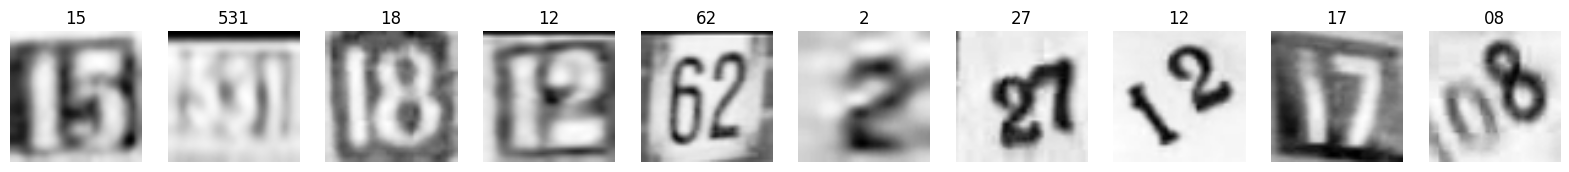

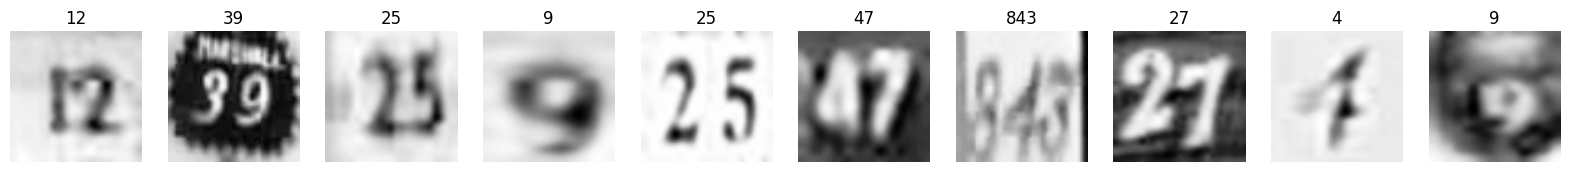

In [24]:
display_images(trainDatasetGray, trainLabels)
display_images(testDatasetGray, testLabels)

In [25]:
import collections
print(collections.Counter(trainLabels[:,0]))
print(collections.Counter(validLabels[:,0]))
print(collections.Counter(testLabels[:,0]))

Counter({2: 18130, 3: 8691, 1: 5137, 4: 1434, 5: 9})
Counter({2: 2990, 3: 1545, 1: 988, 4: 159, 5: 2})
Counter({2: 8356, 1: 2483, 3: 2081, 4: 146, 5: 2})


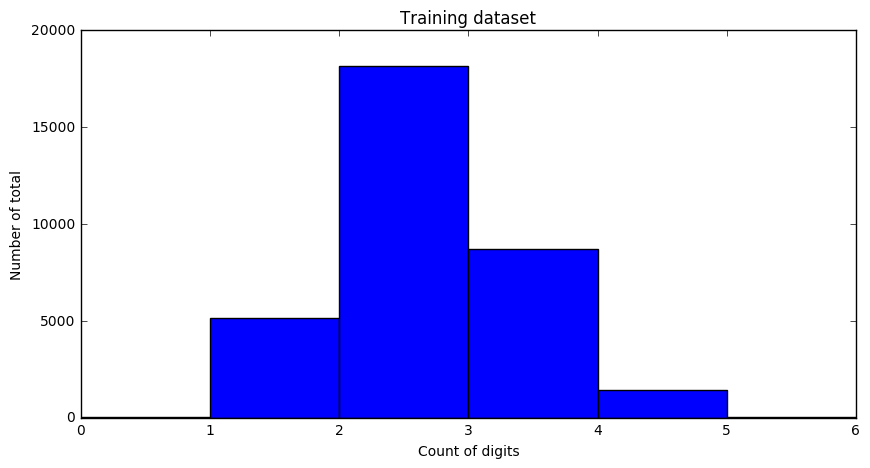

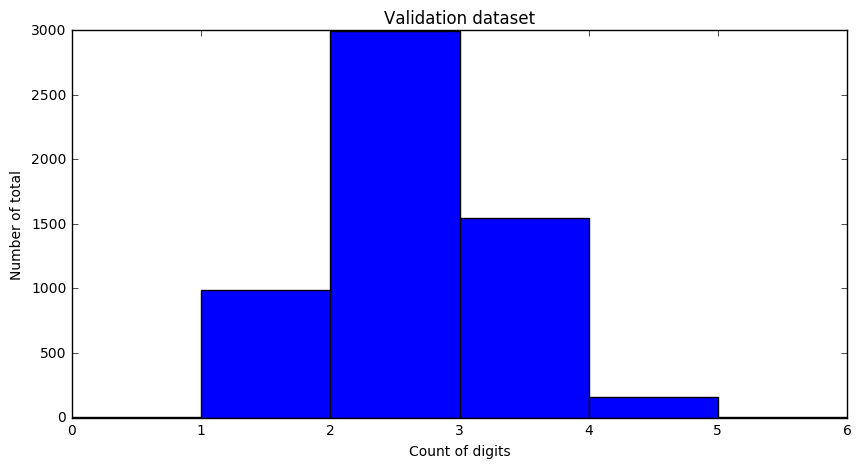

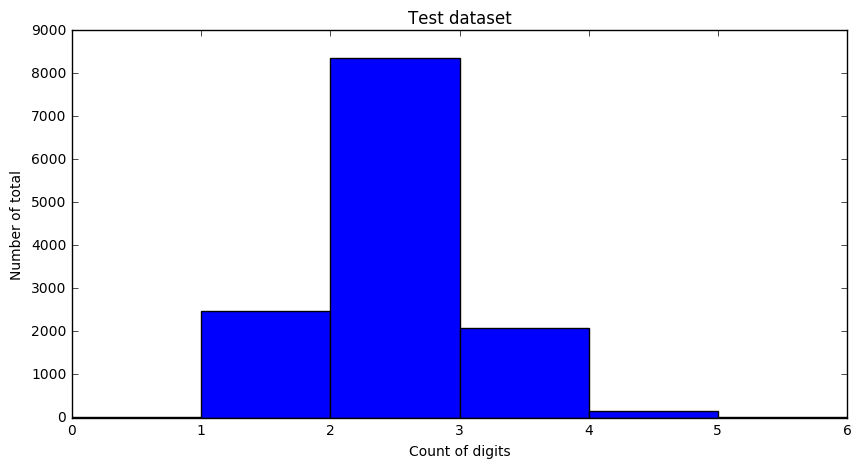

In [26]:
fig = plt.figure(figsize=(10, 5))
plt.title("Training dataset")
plt.xlabel("Count of digits")
plt.ylabel("Number of total")
plt.hist(trainLabels[:,0],[0,1,2,3,4,5,6])
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.title("Validation dataset")
plt.xlabel("Count of digits")
plt.ylabel("Number of total")
plt.hist(validLabels[:,0],[0,1,2,3,4,5,6])
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.title("Test dataset")
plt.xlabel("Count of digits")
plt.ylabel("Number of total")
plt.hist(testLabels[:,0],[0,1,2,3,4,5,6])
plt.show()